```
Licensed Materials - Property of IBM
IBM Maximo APM - Predictive Maintenance Insights On-Premises
IBM Maximo APM - Predictive Maintenance Insights SaaS 
IBM Maximo Application Suite
© Copyright IBM Corp. 2019,2020,2021,2022 All Rights Reserved.
US Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp.
```

In [97]:
!hostname

jupyter-py39-efc5eb56-96d9-45b6-b5b3-d4ba9317a263-6b676578x6k42


## Part 1 - Introduction


The notebooks use a sample dataset to show how data can be ingested, and loaded into the backend systems in Maximo-Predict before a data scientist can proceed to train the models.

This notebook should be run to setup the data in Maximo-Predict before scoring. The following flow chart illustrates the sequence of steps, following which this demo can be adapted for any dataset.

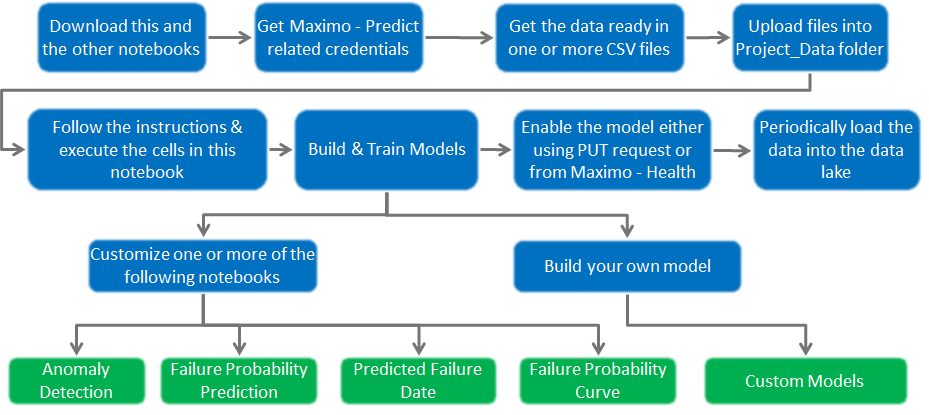

There are 2 notebooks provided including this one. This notebook creates the objects in Maximo-Predict, and loads the essential data into the systems.

This notebook performs a series of operations involving Maximo-Predict as outlined in the following flowchart. Note that it is preferable to delete the objects in the system before recreating them for the demo purposes. The following diagram shows the sequences of delete operations and create operations performed in this notebook. Not following this recommendation could leave corrupt entries behind  causing errors and poor results. 

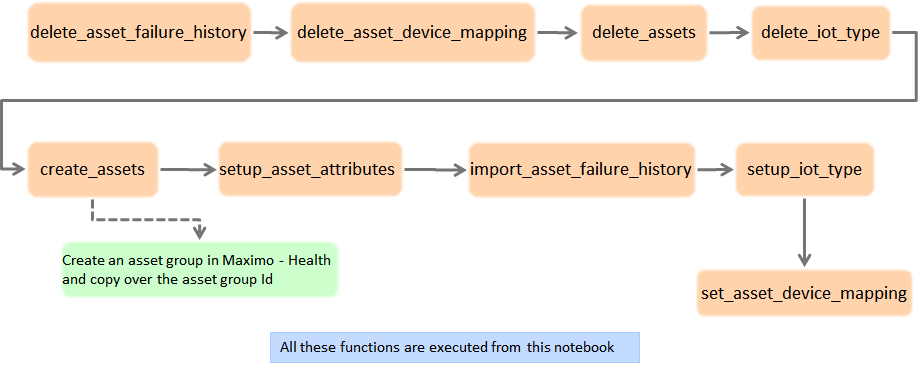

A brief explanation of these operations is as follows

+ **asset_device_mapping**: In reality, assets and their observation (from sensor readings) are usually processed separately. In most cases, asset and sensor data come from and managed by different systems. Maximo-Predict supports getting asset data stored and managed by Maximo, and sensor data from Watson IoT Platform. Assets and sensors are different entities and in order to use both data together, we need to link individual assets and sensors. This is what asset-device mapping is for. Essentially, it indicates for a sensor reading comes in which asset the reading belongs to. An asset can be associated with one or more sensors. On the other hand, a sensor can also be linked to multiple assets, though not common.

+ **Site**: In Maximo, to uniquely identify an asset, you need a site and an asset ID. There are many considerations in planning Maximo organization and site structures, but for our purpose, using assets in Maximo-Predict, we need both site and asset ID in order to identify an asset. If you don't have any site created yet, it's fine to start with site 'BEDFORD' which comes with the sample data set in Maximo.

#### Prerequisites for building the demo

+ Obtain access to Maximo-Predict
+ Get the datasets ready as CSV files (see below)
+ Load all the notebooks into your Watson Studio project

#### Maximo-Predict requires following csv files (dataframes). If your csv files are not in the same format you will need to convert them. We will show you an example in this notebook. 

As you can see in the following formats, there are things that come from your dataset. For example, things like `asset_id` (12 char or less), which is the id of the asset being analyzed, monitored, and studied. However things like `site`, and `devicetype` are the ones you configure in Maximo and IoT platform before embarking on this exercise. 

Except where stated explicitly, the names of the columns are up to the user's choice. It is a matter of preference whether you call it `asset_id` or `equipment_id`. However if your dataset involves a column name different from the one shown here in the example, you need to change the pandas function accordingly in one or more cells below. If you would rather avoid that exercise, then prepare your data using the following structure including the column names to the extent possible. 

Likewise the variable names are also changeable. Instead of calling your IoT object `devicetype`, you can choose to call it `iot_device_type`, so that you can use the word `devicetype` (or `device_type`) for something in your dataset. But if you choose to change any of the variables declared here, then it is important you modify the place(s) where the variables are used.

It should be noted that the column names could be case sensitive in various systems, and certainly so in Pandas. Therefore it is safer to use a consistent case across your variables and other names.

+ Combined Asset and Asset Attribute csv file (dataframe) format -

| asset_id | installation_timestamp | site |
| ----- | ----- | ---- |  
| LOBA20 | 2017-01-19 05:46:29 | BEDFORD|  

+ Asset failure history csv file (dataframe) format -

| asset_id | timestamp | site | deviceid |
|------------| ------- | ------------ | ------ |
| LOBA20 |  2017-01-19 23:29:00 | BEDFORD | LOBSensor20191004_1 |
| LOBA20 |  2017-02-07 00:18:00 | BEDFORD | LOBSensor20191004_1 |
| LOBA20 |  2017-02-08 09:20:00 | BEDFORD | LOBSensor20191004_1 |
| LOBA20 |  2017-02-09 09:06:00 | BEDFORD | LOBSensor20191004_1 |
| LOBA20 |  2017-02-17 13:41:00 | BEDFORD | LOBSensor20191004_1 |

+ IOT sensor csv file (dataframe) format -


| asset_id | timestamp | var1 | var2| var3 | ...... | var_n| deviceid | devicetype |
|------------| ------- | ------------ | ------ | -------|-------|--------|------------|----------------|
| LOBA20 |  2017-01-19 23:29:00 | 34.35 | 65.86 |467.39| ....| 464.73|LOBSensor20191004_1 | LOBSensor20191004 |
| LOBA20 |  2017-01-21 17:38:48 | 47.48 | 38.59 | 483.49| ....|463.59|LOBSensor20191004_1 | LOBSensor20191004 |
| LOBA20 |  2017-01-19 21:59:37 | 36.67 | 37.76 | 294.65| ....|120.57|LOBSensor20191004_1 | LOBSensor20191004 |


+ Asset-Device mapping csv file (dataframe) format - 

| asset_id | site   | deviceid | devicetype|
|------------| ------- | ------------ | ------ |
| LOBA20 |  BEDFORD | LOBSensor20191004_1 | LOBSensor20191004 |
| LOBA20 |  BEDFORD | LOBSensor20191004_1 | LOBSensor20191004 |
| LOBA20 |  BEDFORD | LOBSensor20191004_1 | LOBSensor20191004 |

## Install the Maximo Predict SDK

You will need follow 4 credentials to run the notebook. You can obtain first 3 credentials if you are admin on Maximo Predict UI. Otherwise, you will have to get these from your admin.

You will only have to follow these steps for the first notebook. So, if you have already created the `Predict_Envs.json` file, you can skip ahead to running this notebook.

Steps

- APM_ID: Application Administration -> System Properties -> Filter -> Search PMIId -> Current Value
- APM_API_BASEURL: Application Administration -> Integration -> End Points-> Searh for predict -> click search result PREDICTAPI -> URL (note you just need first part of the url)
- APM_API_KEY: Application Administration -> Go To Administration -> Copy key from user card, or Add API key for the user if API key does not exist.

Step to get db2_certificate.pem:

- Login CP4D. Click Services->Instances. Click the Predict DB. Click "Download SSL Certificate" and save it to the file named as db2_certificate.pem. Then upload the db2_certificate.pem to the CP4D by click "New data Asset".

These can then be placed in a file called `Predict_Envs.json`, formatted like this:

```json
{
  "APM_ID": "a1b1c1d1",
  "APM_API_BASEURL": "https://predict-url.svc",
  "APM_API_KEY": "aaabbbcccdddeeefffggghhhiiijjjkkklllmmmn"
}
```

The three `USER_PROVIDED_*` fields are only necessary if connecting to a deployment not in this CP4D environment.

After creating the JSON file, add it as a data asset to the current project in CP4D.

The code below pulls the credentials from that JSON file and sets them as environment variables in this runtime.

In [98]:
import json
import os

# Opening JSON file
f = open('/project_data/data_asset/Predict_Envs.json',)
data = json.load(f)
print(data)
f.close()

os.environ['APM_ID'] = data['APM_ID']
os.environ['APM_API_BASEURL'] = data['APM_API_BASEURL']
os.environ['APM_API_KEY'] = data['APM_API_KEY']

# README: Change to true if Health/Predict are deployed on different cluster from this CP4D environment
use_external = False
if use_external:
    import os
    #os.environ['USER_PROVIDED_HEALTH_URL'] = data['USER_PROVIDED_HEALTH_URL']
    os.environ['USER_PROVIDED_HEALTH_URL'] =data['USER_PROVIDED_HEALTH_URL']
    os.environ['USER_PROVIDED_DB_CONNECTION_STRING'] = data['USER_PROVIDED_DB_CONNECTION_STRING']
    os.environ['USER_PROVIDED_WML_URL'] = data['USER_PROVIDED_URL']

{'APM_ID': 'main', 'APM_API_BASEURL': 'https://ivt15rel89-predict-api.mas-ivt15rel89-predict.svc', 'APM_API_KEY': '8vrinkcnu82svi1k3345rs9ovq8dleq5n11hfb9j', 'EXTERNAL_APM_API_BASEURL': '', 'USER_PROVIDED_HEALTH_URL': '', 'USER_PROVIDED_DB_CONNECTION_STRING': '', 'USER_PROVIDED_URL': ''}


In [54]:
#os.environ['USER_PROVIDED_HEALTH_URL'] ='https://masdev.manage.devtest.hpdevcloud-69c05213eaa787de914409cbc9e5bcab-0000.us-south.containers.appdomain.cloud/maximo'

In [6]:
# import os
# monitor_url='https://masdev.api.monitor.devtest.hpdevcloud-69c05213eaa787de914409cbc9e5bcab-0000.us-south.containers.appdomain.cloud'
# os.environ['isICP']='true'

# os.environ['REST_METADATA_URL']=monitor_url

# os.environ['REST_KPI_URL']=monitor_url

In [99]:
import os

os.environ['SSL_VERIFY_APM'] = 'False'
os.environ['SSL_VERIFY_AS'] = 'False'

os.environ['TRUST_PREDICT'] = os.getenv('APM_API_BASEURL')[8:]
print(os.getenv('TRUST_PREDICT'))

ivt15rel89-predict-api.mas-ivt15rel89-predict.svc


In [100]:
import os
os.environ['TRUST_PREDICT'] = os.getenv('APM_API_BASEURL')[8:]
print(os.getenv('TRUST_PREDICT'))

ivt15rel89-predict-api.mas-ivt15rel89-predict.svc


Finally, install pmlib with `pip`:

In [101]:

%time !pip install --trusted-host ${TRUST_PREDICT} ${APM_API_BASEURL}/ibm/pmi/service/rest/ds/${APM_ID}/${APM_API_KEY}/lib/download?filename=pmlib

     |████████████████████████████████| 157.0 MB 33.7 MB/s eta 0:00:01                   | 266 kB 42.2 MB/s eta 0:00:04     |███▊                            | 18.3 MB 42.2 MB/s eta 0:00:04     |█████████▋                      | 47.0 MB 42.2 MB/s eta 0:00:039 MB 3.4 MB/s eta 0:00:17��████████████████████▎          | 104.2 MB 3.4 MB/s eta 0:00:16
Processing //tmp/1000650000/pip-req-build-z7qf6_6p/dslib/watson_data_client-1.0.0-cp39-cp39-linux_x86_64.whl
Processing //tmp/1000650000/pip-req-build-z7qf6_6p/dslib/mat_sdk-0.28.2.zip
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
Processing //tmp/1000650000/pip-req-build-z7qf6_6p/dslib/aixclient.zip
Processing //tmp/1000650000/pip-req-build-z7qf6_6p/dslib/modelfactory-0.0.10.1.0-cp39-cp39-linux_x86_64.whl
Processing //tmp/1000650000/pip-req-build-z7qf6_6p/dslib/srom-1.6.3.1.0-cp39-cp39-linux_x86_64.whl
Processing //tmp/1000

In [114]:
# Initialize the Maximo-Predict environment variables

import pmlib
from pmlib import api
api.init_environ()

('main',
 'https://ivt15rel89-predict-api.mas-ivt15rel89-predict.svc',
 '8vrinkcnu82svi1k3345rs9ovq8dleq5n11hfb9j')

In [115]:
import pandas as pd
import numpy as np
import requests

import json
import os
import time
from datetime import datetime
from datetime import timedelta
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simple_filter = simplefilter(action='once', category=UserWarning)

In [116]:
# define column name variables so they are consistent
install_date_col_name = 'installdate'
timestamp_col_name = 'evt_timestamp'
site_id_col_name = 'site_id'

fail_date_col_name = 'fail_date'
decommission_date_col_name = 'decommission_date'
asset_id_col_name = 'asset_id'
device_type_col_name = 'devicetype'
device_id_col_name = 'deviceid'

# Step 1: Make 1 million record for testing. We did testing of 8 million records

In [104]:
import numpy as np
test_data = np.random.normal(25.7, 7.6, (1000000,25))

In [107]:
test_df=pd.DataFrame(test_data,columns=['v'+str(i) for i in range(25)])
test_df['deviceid']=np.random.choice(['asset1','asset2','asset3'],test_df.shape[0] )
# 1 second frequence
test_df['evt_timestamp']=pd.date_range('2022-01-01',periods=test_df.shape[0],freq='1s')

In [108]:
test_df.head(10)

v0         v1         v2         v3         v4         v5  \
0  29.869789  32.484462  24.405339  13.192204  26.859083  26.375603   
1  18.501698  17.108872  28.057628  30.047926  18.482265  15.784065   
2  27.808641  14.881611  26.966024  28.818590  17.771971  33.911730   
3  28.256682  14.009980  21.395525  31.117831  30.682615  21.014478   
4  30.474893  30.911727  23.735014  14.744370   7.056320  28.979156   
5  26.049173  25.036065  36.429218  32.618396  30.232429  32.820770   
6  25.610859  18.181670  31.041285  22.751014  11.444051  28.128720   
7  22.297749  23.320642  15.495210  22.847767  34.044349  16.481784   
8  31.174901  21.490875  19.853392  15.021004  22.798415  26.815722   
9  25.095928  30.780699  25.343315  29.592927  21.300423  32.600866   

          v6         v7         v8         v9  ...        v17        v18  \
0  34.534176  14.961816  29.897944  25.435550  ...  22.847144  28.591852   
1  31.165153  22.063442  15.423515  15.726100  ...  33.635293  34.838608   
2  17.258959  21.550779  21.059312  22.974459  ...  32.069657  31.218663   
3  11.666646  18.715463  25.282040  38.093331  ...  34.541368  33.596978   
4  13.601233  28.756888  23.864102  16.128453  ...  26.922245  26.554681   
5  20.749701  27.875636  16.262340  10.907814  ...  25.953285  28.496613   
6  19.271136  13.043010   8.673795  32.065199  ...  30.905493  30.580421   
7  27.147798  13.723823   9.552223  32.275503  ...  40.887002  21.628041   
8  14.527739  25.171430  30.959204  23.249482  ...  41.765368  21.816899   
9  17.439694  32.753086  35.818072  29.828607  ...  21.892166  27.565945   

         v19        v20        v21        v22        v23        v24  deviceid  \
0  26.566689  41.526307  27.173857  36.720479  29.479953  19.041388    asset1   
1  36.034888  26.516670  27.736703  15.551240  30.554004  33.312097    asset1   
2  42.995682  29.914428  26.011625  28.222634  21.099835  10.787181    asset3   
3  16.875035  28.681829  29.218229  19.060396  15.019551  35.957271    asset2   
4  26.342215  26.816394  19.103442  27.460765  31.638972  29.506028    asset2   
5  30.766277  28.490867  35.425393  18.963929  30.645255  28.384165    asset2   
6  22.214346  10.333519  27.590503  12.305694  29.421983  27.418754    asset2   
7  37.648695  33.610689  24.354105  42.852710  33.236640  27.043244    asset3   
8  28.485619  27.520442  17.108327  20.326228  25.677639  28.334544    asset3   
9  26.837752  26.322048  35.330140  16.294732  29.362655  23.106255    asset1   

        evt_timestamp  
0 2022-01-01 00:00:00  
1 2022-01-01 00:00:01  
2 2022-01-01 00:00:02  
3 2022-01-01 00:00:03  
4 2022-01-01 00:00:04  
5 2022-01-01 00:00:05  
6 2022-01-01 00:00:06  
7 2022-01-01 00:00:07  
8 2022-01-01 00:00:08  
9 2022-01-01 00:00:09  

[10 rows x 27 columns]

In [109]:
test_df.tail(10)

v0         v1         v2         v3         v4         v5  \
999990  32.277308  23.665655  34.803307  23.084933  20.595237  27.286227   
999991  21.067411  14.974581  41.310297  35.715523  23.162243  32.693454   
999992  25.787420  24.626441  23.057264  20.257720   4.786746  25.533222   
999993  27.776923  24.997144  33.364292  32.641656  40.652991  29.349977   
999994  26.202818  28.668459  30.566482  31.910932  19.847630  25.171818   
999995  22.757584  31.918938  23.982964  29.928650  16.203163  38.747270   
999996  18.182225  29.044632  33.760393  27.893206  27.480150  12.857059   
999997  21.419920  18.785491  36.288532  17.715739  35.503659  37.973959   
999998   7.609554  18.202517  29.486557  39.064189  27.804625  19.355456   
999999  31.529460  34.853529  33.557633  14.721075  26.347498  33.609495   

               v6         v7         v8         v9  ...        v17        v18  \
999990  48.038130  20.494982  22.493525  28.055922  ...  32.596051  31.858091   
999991  33.294273  24.957997  26.324985  38.144879  ...  37.336261  34.788153   
999992  24.393361  31.031225  26.194223  25.640496  ...  21.117469  26.826136   
999993  27.138926  28.878726  27.379749  27.647393  ...  15.428235  30.687376   
999994  36.157916  31.075278  30.853826  28.784652  ...  25.416119  27.284667   
999995  17.529393  28.535514  17.623753  27.082559  ...  30.098661  14.164503   
999996  36.704629  30.944746  19.012853  25.273546  ...  22.474653  23.937672   
999997  27.654887  11.826562  13.686531  27.284004  ...  21.375206  21.356855   
999998  24.798338  14.852746  26.641926  22.780680  ...  37.438149  17.943269   
999999  26.055773  23.862382  35.542456  30.937637  ...   7.311850  36.814451   

              v19        v20        v21        v22        v23        v24  \
999990  15.245348  37.986108  33.858199  29.925952  25.049649  30.776464   
999991  26.411164  37.882030  23.143552  28.758060  33.455995  22.537491   
999992  22.943526  31.396094  32.526232  20.450670  40.350773  28.066896   
999993  29.474372  28.273592  29.919271  33.674495  21.787336  18.882410   
999994  23.270554  19.123034  14.635416  22.788592  31.042930  32.339238   
999995  33.021387  36.208681  23.066285  29.313152  43.463105  27.340330   
999996  36.523807   9.673916  26.192588  22.900156  22.697431  39.245039   
999997  27.622562  28.922668  28.300398  20.796730  31.755205  17.100206   
999998  28.877228  15.046087  37.615274  24.411834  22.807659  23.292323   
999999  21.116207  22.712872  13.904562  14.112479  27.070770  13.944803   

        deviceid       evt_timestamp  
999990    asset1 2022-01-12 13:46:30  
999991    asset2 2022-01-12 13:46:31  
999992    asset1 2022-01-12 13:46:32  
999993    asset2 2022-01-12 13:46:33  
999994    asset3 2022-01-12 13:46:34  
999995    asset2 2022-01-12 13:46:35  
999996    asset1 2022-01-12 13:46:36  
999997    asset2 2022-01-12 13:46:37  
999998    asset3 2022-01-12 13:46:38  
999999    asset2 2022-01-12 13:46:39  

[10 rows x 27 columns]

# Step 2: from test_df.head(10), we know the first 4 rows has all the asset1, asset2 and asset3

In [110]:
first_4_df=test_df.head(4)

In [111]:
first_4_df

v0         v1         v2         v3         v4         v5  \
0  29.869789  32.484462  24.405339  13.192204  26.859083  26.375603   
1  18.501698  17.108872  28.057628  30.047926  18.482265  15.784065   
2  27.808641  14.881611  26.966024  28.818590  17.771971  33.911730   
3  28.256682  14.009980  21.395525  31.117831  30.682615  21.014478   

          v6         v7         v8         v9  ...        v17        v18  \
0  34.534176  14.961816  29.897944  25.435550  ...  22.847144  28.591852   
1  31.165153  22.063442  15.423515  15.726100  ...  33.635293  34.838608   
2  17.258959  21.550779  21.059312  22.974459  ...  32.069657  31.218663   
3  11.666646  18.715463  25.282040  38.093331  ...  34.541368  33.596978   

         v19        v20        v21        v22        v23        v24  deviceid  \
0  26.566689  41.526307  27.173857  36.720479  29.479953  19.041388    asset1   
1  36.034888  26.516670  27.736703  15.551240  30.554004  33.312097    asset1   
2  42.995682  29.914428  26.011625  28.222634  21.099835  10.787181    asset3   
3  16.875035  28.681829  29.218229  19.060396  15.019551  35.957271    asset2   

        evt_timestamp  
0 2022-01-01 00:00:00  
1 2022-01-01 00:00:01  
2 2022-01-01 00:00:02  
3 2022-01-01 00:00:03  

[4 rows x 27 columns]

In [112]:
column_list=['v'+str(i) for i in range(25)]
column_list

['v0',
 'v1',
 'v2',
 'v3',
 'v4',
 'v5',
 'v6',
 'v7',
 'v8',
 'v9',
 'v10',
 'v11',
 'v12',
 'v13',
 'v14',
 'v15',
 'v16',
 'v17',
 'v18',
 'v19',
 'v20',
 'v21',
 'v22',
 'v23',
 'v24']

In [113]:
device_type_afm = 'new_big_table'
first_4_df['devicetype']=device_type_afm
first_4_df

v0         v1         v2         v3         v4         v5  \
0  29.869789  32.484462  24.405339  13.192204  26.859083  26.375603   
1  18.501698  17.108872  28.057628  30.047926  18.482265  15.784065   
2  27.808641  14.881611  26.966024  28.818590  17.771971  33.911730   
3  28.256682  14.009980  21.395525  31.117831  30.682615  21.014478   

          v6         v7         v8         v9  ...        v18        v19  \
0  34.534176  14.961816  29.897944  25.435550  ...  28.591852  26.566689   
1  31.165153  22.063442  15.423515  15.726100  ...  34.838608  36.034888   
2  17.258959  21.550779  21.059312  22.974459  ...  31.218663  42.995682   
3  11.666646  18.715463  25.282040  38.093331  ...  33.596978  16.875035   

         v20        v21        v22        v23        v24  deviceid  \
0  41.526307  27.173857  36.720479  29.479953  19.041388    asset1   
1  26.516670  27.736703  15.551240  30.554004  33.312097    asset1   
2  29.914428  26.011625  28.222634  21.099835  10.787181    asset3   
3  28.681829  29.218229  19.060396  15.019551  35.957271    asset2   

        evt_timestamp     devicetype  
0 2022-01-01 00:00:00  new_big_table  
1 2022-01-01 00:00:01  new_big_table  
2 2022-01-01 00:00:02  new_big_table  
3 2022-01-01 00:00:03  new_big_table  

[4 rows x 28 columns]

# Step 3: create the device type and insert the first 4 records to get the device_uid for the all assets

In [117]:
# Loading the training data. Note that this training data is used from a CSV file in a separate notebook
t = pmlib.setup_iot_type_v2(
    name=device_type_afm,
    df=first_4_df,
    columns=column_list,
    deviceid_column=device_id_col_name,
    timestamp_column=timestamp_col_name,
    timestamp_in_payload=True,
    # write='deletefirst',
    write='dropfirst',
    use_wiotp=True,  # may create extra rows
    import_only=False)  # True or False depends on whether your device type is already there in the system or not.

2022-10-14T20:38:05.193 DEBUG::pmlib.api._call_wiotp: Calling WIOTP...
2022-10-14T20:38:05.194 DEBUG::pmlib.api._call_wiotp: WIOTP Call URL: https://main.iot.ivt15rel89.ivt.suite.maximo.com
2022-10-14T20:38:05.198 INFO::pmlib.util.api_request: Making API Request: method=get, url=https://main.iot.ivt15rel89.ivt.suite.maximo.com/api/v0002/device/types/new_big_table, headers={}, timeout=300, ssl_verify=False, json=None, session=None, kwargs={'auth': ('a-main-lol7nsvijq', '&asMkxtM*IqAyxbZY4')}
2022-10-14T20:38:05.479 INFO::pmlib.util.api_request: Received API Response: resp.status_code=404, method=get, url=https://main.iot.ivt15rel89.ivt.suite.maximo.com/api/v0002/device/types/new_big_table
2022-10-14T20:38:05.480 WARNING::pmlib.util.api_request: Unsuccessful api request: url=https://main.iot.ivt15rel89.ivt.suite.maximo.com/api/v0002/device/types/new_big_table, method=get, status_code=404, response_text={"message":"CUDRS0054E: Device type new_big_table does not exist in this organization.

# Step 4: from the above log , we know the table name is IOT_NEW_BIG_TABLE_4353. Please change it for your new table name

In [120]:
table_name='IOT_NEW_BIG_TABLE_4353'
table_name

'IOT_NEW_BIG_TABLE_4353'

In [121]:
from pmlib import api
db=api._get_db()

2022-10-14T20:39:57.234 DEBUG::pmlib.api._get_db: Request made to retrieve DB...
2022-10-14T20:39:57.236 DEBUG::pmlib.api._get_db: Database Type: db2
2022-10-14T20:40:00.361 DEBUG::pmlib.api._get_db: Retrieved db.model_store.entity_type_id=None
2022-10-14T20:40:00.362 DEBUG::pmlib.api._get_db: Successfully retrieved DB2 database


In [122]:
db_schema = api.get_as_schema(db_schema=None)
db_schema

'MAIN_MAM'

# Step 5: you need go to DB2, check the table_name='IOT_NEW_BIG_TABLE_4353' to find out the device_uid for each asset

In [123]:
device_uid_map = {'asset1':1419, 'asset2': 1421, 'asset3':1420}

In [124]:
df= test_df.loc[4:]  # get rest record

In [125]:
df.head(10)

v0         v1         v2         v3         v4         v5  \
4   30.474893  30.911727  23.735014  14.744370   7.056320  28.979156   
5   26.049173  25.036065  36.429218  32.618396  30.232429  32.820770   
6   25.610859  18.181670  31.041285  22.751014  11.444051  28.128720   
7   22.297749  23.320642  15.495210  22.847767  34.044349  16.481784   
8   31.174901  21.490875  19.853392  15.021004  22.798415  26.815722   
9   25.095928  30.780699  25.343315  29.592927  21.300423  32.600866   
10  18.385384  39.109141  26.465365  39.803455  19.620272  19.329317   
11  15.637886  29.342916  33.649714  40.779837  21.959776  29.424870   
12  18.538410  26.508421  22.157250  34.869839  27.691144  14.002722   
13  20.168127  22.194222  20.237553  29.495615  32.564830  34.038287   

           v6         v7         v8         v9  ...        v17        v18  \
4   13.601233  28.756888  23.864102  16.128453  ...  26.922245  26.554681   
5   20.749701  27.875636  16.262340  10.907814  ...  25.953285  28.496613   
6   19.271136  13.043010   8.673795  32.065199  ...  30.905493  30.580421   
7   27.147798  13.723823   9.552223  32.275503  ...  40.887002  21.628041   
8   14.527739  25.171430  30.959204  23.249482  ...  41.765368  21.816899   
9   17.439694  32.753086  35.818072  29.828607  ...  21.892166  27.565945   
10  18.892883  29.793820  24.588970  16.439866  ...  32.937698  24.822143   
11  21.514146  27.939056  30.359348  22.059281  ...  26.112133  24.062192   
12  22.545452  20.810517  19.091026  24.584140  ...  25.679143  37.112537   
13  27.660438  16.464813  17.789432  23.707903  ...  10.550701  29.331122   

          v19        v20        v21        v22        v23        v24  \
4   26.342215  26.816394  19.103442  27.460765  31.638972  29.506028   
5   30.766277  28.490867  35.425393  18.963929  30.645255  28.384165   
6   22.214346  10.333519  27.590503  12.305694  29.421983  27.418754   
7   37.648695  33.610689  24.354105  42.852710  33.236640  27.043244   
8   28.485619  27.520442  17.108327  20.326228  25.677639  28.334544   
9   26.837752  26.322048  35.330140  16.294732  29.362655  23.106255   
10  43.914134  34.308827  32.165160  40.611226  25.388675  11.259251   
11  24.794780  26.689559  24.966525  31.950013  25.320853  27.746836   
12  30.595975  26.586779  34.182251  17.750336  21.953412  19.119855   
13  13.007393  18.283876  29.510573  16.366168  30.432791  27.397988   

    deviceid       evt_timestamp  
4     asset2 2022-01-01 00:00:04  
5     asset2 2022-01-01 00:00:05  
6     asset2 2022-01-01 00:00:06  
7     asset3 2022-01-01 00:00:07  
8     asset3 2022-01-01 00:00:08  
9     asset1 2022-01-01 00:00:09  
10    asset2 2022-01-01 00:00:10  
11    asset2 2022-01-01 00:00:11  
12    asset3 2022-01-01 00:00:12  
13    asset2 2022-01-01 00:00:13  

[10 rows x 27 columns]

In [126]:
df.shape

(999996, 27)

# Step 6: set the device_uid_map

In [127]:
df['device_uid'] = df['deviceid'].map(device_uid_map)

In [128]:
df.head(10)

v0         v1         v2         v3         v4         v5  \
4   30.474893  30.911727  23.735014  14.744370   7.056320  28.979156   
5   26.049173  25.036065  36.429218  32.618396  30.232429  32.820770   
6   25.610859  18.181670  31.041285  22.751014  11.444051  28.128720   
7   22.297749  23.320642  15.495210  22.847767  34.044349  16.481784   
8   31.174901  21.490875  19.853392  15.021004  22.798415  26.815722   
9   25.095928  30.780699  25.343315  29.592927  21.300423  32.600866   
10  18.385384  39.109141  26.465365  39.803455  19.620272  19.329317   
11  15.637886  29.342916  33.649714  40.779837  21.959776  29.424870   
12  18.538410  26.508421  22.157250  34.869839  27.691144  14.002722   
13  20.168127  22.194222  20.237553  29.495615  32.564830  34.038287   

           v6         v7         v8         v9  ...        v18        v19  \
4   13.601233  28.756888  23.864102  16.128453  ...  26.554681  26.342215   
5   20.749701  27.875636  16.262340  10.907814  ...  28.496613  30.766277   
6   19.271136  13.043010   8.673795  32.065199  ...  30.580421  22.214346   
7   27.147798  13.723823   9.552223  32.275503  ...  21.628041  37.648695   
8   14.527739  25.171430  30.959204  23.249482  ...  21.816899  28.485619   
9   17.439694  32.753086  35.818072  29.828607  ...  27.565945  26.837752   
10  18.892883  29.793820  24.588970  16.439866  ...  24.822143  43.914134   
11  21.514146  27.939056  30.359348  22.059281  ...  24.062192  24.794780   
12  22.545452  20.810517  19.091026  24.584140  ...  37.112537  30.595975   
13  27.660438  16.464813  17.789432  23.707903  ...  29.331122  13.007393   

          v20        v21        v22        v23        v24  deviceid  \
4   26.816394  19.103442  27.460765  31.638972  29.506028    asset2   
5   28.490867  35.425393  18.963929  30.645255  28.384165    asset2   
6   10.333519  27.590503  12.305694  29.421983  27.418754    asset2   
7   33.610689  24.354105  42.852710  33.236640  27.043244    asset3   
8   27.520442  17.108327  20.326228  25.677639  28.334544    asset3   
9   26.322048  35.330140  16.294732  29.362655  23.106255    asset1   
10  34.308827  32.165160  40.611226  25.388675  11.259251    asset2   
11  26.689559  24.966525  31.950013  25.320853  27.746836    asset2   
12  26.586779  34.182251  17.750336  21.953412  19.119855    asset3   
13  18.283876  29.510573  16.366168  30.432791  27.397988    asset2   

         evt_timestamp  device_uid  
4  2022-01-01 00:00:04        1421  
5  2022-01-01 00:00:05        1421  
6  2022-01-01 00:00:06        1421  
7  2022-01-01 00:00:07        1420  
8  2022-01-01 00:00:08        1420  
9  2022-01-01 00:00:09        1419  
10 2022-01-01 00:00:10        1421  
11 2022-01-01 00:00:11        1421  
12 2022-01-01 00:00:12        1420  
13 2022-01-01 00:00:13        1421  

[10 rows x 28 columns]

# Step 7: create partition

In [129]:
start_date, end_date = api.get_start_date_and_end_date(df,timestamp_col_name)
    
day_count = (end_date - start_date).days + 1
for single_date in (start_date + timedelta(n) for n in range(day_count)):
    day_begin, day_end, partition_name= api.get_start_date_and_end_date_utc_and_partition_name(single_date)
    print(day_begin)
    print(day_end)
    #logger.debug('single_date = %s, day_begin = %s, day_end = %s, partition_name = %s', single_date, day_begin, day_end, partition_name)
    api.create_partition_for_one_day(db,table_name,partition_name,day_begin,day_end)

2022-10-14T20:45:50.537 DEBUG::pmlib.api.get_start_date_and_end_date: 2022-01-01 00:00:04
2022-10-14T20:45:50.542 DEBUG::pmlib.api.get_start_date_and_end_date: 2022-01-12 13:46:39
2022-01-01-00.00.00.000000
2022-01-01-23.59.59.999999
2022-10-14T20:45:50.544 DEBUG::pmlib.api.create_partition_for_one_day:  ALTER TABLE MAIN_MAM.IOT_NEW_BIG_TABLE_4353 ADD PARTITION 20220101 STARTING ('2022-01-01-00.00.00.000000') ENDING('2022-01-01-23.59.59.999999')
2022-10-14T20:45:50.554 DEBUG::pmlib.api.create_partition_for_one_day: (ibm_db_dbi.ProgrammingError) ibm_db_dbi::ProgrammingError: Statement Execute Failed: [IBM][CLI Driver][DB2/LINUXX8664] SQL0601N  The name of the object to be created is identical to the existing name "20220101" of type "PARTITION NAME".  SQLSTATE=42710 SQLCODE=-601
[SQL:  ALTER TABLE MAIN_MAM.IOT_NEW_BIG_TABLE_4353 ADD PARTITION 20220101 STARTING ('2022-01-01-00.00.00.000000') ENDING('2022-01-01-23.59.59.999999')]
(Background on this error at: https://sqlalche.me/e/14/f405)

In [130]:
print(df.shape)

(999996, 28)


In [131]:
table_name

'IOT_NEW_BIG_TABLE_4353'

In [132]:
def is_bool_dtype(arr_or_dtype) -> bool: ...
def is_string_dtype(arr_or_dtype) -> bool: ...

In [133]:
if_exists='append'
chunksize = db.write_chunk_size
chunksize

1000

In [134]:
# use a default type mapping for strings and booleans
dtypes = {}
for c in list(df.columns):
    if is_string_dtype(df[c]):
        dtypes[c] = String(255)
    elif is_bool_dtype(df[c]):
        dtypes[c] = SmallInteger()

In [135]:
df['RCV_TIMESTAMP_UTC']=df[timestamp_col_name]

In [136]:
df.head(10)

v0         v1         v2         v3         v4         v5  \
4   30.474893  30.911727  23.735014  14.744370   7.056320  28.979156   
5   26.049173  25.036065  36.429218  32.618396  30.232429  32.820770   
6   25.610859  18.181670  31.041285  22.751014  11.444051  28.128720   
7   22.297749  23.320642  15.495210  22.847767  34.044349  16.481784   
8   31.174901  21.490875  19.853392  15.021004  22.798415  26.815722   
9   25.095928  30.780699  25.343315  29.592927  21.300423  32.600866   
10  18.385384  39.109141  26.465365  39.803455  19.620272  19.329317   
11  15.637886  29.342916  33.649714  40.779837  21.959776  29.424870   
12  18.538410  26.508421  22.157250  34.869839  27.691144  14.002722   
13  20.168127  22.194222  20.237553  29.495615  32.564830  34.038287   

           v6         v7         v8         v9  ...        v19        v20  \
4   13.601233  28.756888  23.864102  16.128453  ...  26.342215  26.816394   
5   20.749701  27.875636  16.262340  10.907814  ...  30.766277  28.490867   
6   19.271136  13.043010   8.673795  32.065199  ...  22.214346  10.333519   
7   27.147798  13.723823   9.552223  32.275503  ...  37.648695  33.610689   
8   14.527739  25.171430  30.959204  23.249482  ...  28.485619  27.520442   
9   17.439694  32.753086  35.818072  29.828607  ...  26.837752  26.322048   
10  18.892883  29.793820  24.588970  16.439866  ...  43.914134  34.308827   
11  21.514146  27.939056  30.359348  22.059281  ...  24.794780  26.689559   
12  22.545452  20.810517  19.091026  24.584140  ...  30.595975  26.586779   
13  27.660438  16.464813  17.789432  23.707903  ...  13.007393  18.283876   

          v21        v22        v23        v24  deviceid       evt_timestamp  \
4   19.103442  27.460765  31.638972  29.506028    asset2 2022-01-01 00:00:04   
5   35.425393  18.963929  30.645255  28.384165    asset2 2022-01-01 00:00:05   
6   27.590503  12.305694  29.421983  27.418754    asset2 2022-01-01 00:00:06   
7   24.354105  42.852710  33.236640  27.043244    asset3 2022-01-01 00:00:07   
8   17.108327  20.326228  25.677639  28.334544    asset3 2022-01-01 00:00:08   
9   35.330140  16.294732  29.362655  23.106255    asset1 2022-01-01 00:00:09   
10  32.165160  40.611226  25.388675  11.259251    asset2 2022-01-01 00:00:10   
11  24.966525  31.950013  25.320853  27.746836    asset2 2022-01-01 00:00:11   
12  34.182251  17.750336  21.953412  19.119855    asset3 2022-01-01 00:00:12   
13  29.510573  16.366168  30.432791  27.397988    asset2 2022-01-01 00:00:13   

    device_uid   RCV_TIMESTAMP_UTC  
4         1421 2022-01-01 00:00:04  
5         1421 2022-01-01 00:00:05  
6         1421 2022-01-01 00:00:06  
7         1420 2022-01-01 00:00:07  
8         1420 2022-01-01 00:00:08  
9         1419 2022-01-01 00:00:09  
10        1421 2022-01-01 00:00:10  
11        1421 2022-01-01 00:00:11  
12        1420 2022-01-01 00:00:12  
13        1421 2022-01-01 00:00:13  

[10 rows x 29 columns]

In [137]:
import datetime
print ( datetime.datetime.now())
chunk_size = int(df.shape[0] / 40)

print(chunk_size)

for start in range(0, df.shape[0], chunk_size):
    df_subset = df.iloc[start:start + chunk_size]
    
    
    df_subset.to_sql(name=table_name, con=db.connection, schema=db_schema, if_exists=if_exists, index=False, chunksize=chunksize, dtype=dtypes)
print ( datetime.datetime.now())

2022-10-14 20:48:14.043695
24999
2022-10-14T20:48:21.917 WARNING::py.warnings._showwarnmsg: /opt/conda/envs/Python-3.9/lib/python3.9/site-packages/pandas/io/sql.py:1685: UserWarning: The provided table name 'IOT_NEW_BIG_TABLE_4353' is not found exactly as such in the database after writing the table, possibly due to case sensitivity issues. Consider using lower case table names.
  warnings.warn(msg, UserWarning)

2022-10-14 20:51:29.430024


# Done